## Sigmoid subunit nonlinearity

This notebook produces figure 6.

## Set up

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import scipy.io as sio
from scipy.interpolate import interp1d
sns.set_style("white")

### Model and analysis functions

In [2]:
def Best_ITD(bF,Nitd):
    #bF are the best frequencies of the ICcl neurons (kHz)
    #Nitd is the number of best ITDs of the ICcl neurons at each BF 
    
    Nf = np.size(bF)
    
    bITD = np.zeros((Nf,Nitd))
    
    for n in np.arange(Nf):
        bITD[n,:] = np.linspace(-250,250,Nitd)
        
    return bITD    

In [3]:
def ICcl_Noise(ITD,bF,bITD):
    
    Nf,Nitd = np.shape(bITD)
  
    R = np.zeros((Nf,Nitd))
  
    for n in np.arange(Nf):
        
        b = (17 - np.sqrt(17**2 - 4*2.8*(24.12 - 2.44*bF[n])))/5.6 #From Fujita and Konishi 91
    
        I = np.cos(2*np.pi*bF[n]*(ITD - bITD[n,:])/1000) #assumes ITD, bITD are in us, bF in kHz
    
        R[n,:] = (np.exp(b*I)- np.exp(-b))/(np.exp(b) - np.exp(-b))
   
    return R

In [4]:
def subunit_weights(CF,BW,bF,bITD,bF_sub,bITD_sub,sBF,sITD):
    #Sound properties: CF, BW
    #ICcl properties: bF, bITD
    #ICx subunit properties: bF_sub,bITD_sub,sBF,sITD
    
    Nf, Nitd = np.shape(bITD)

    #Get frequency weights
    Wf = np.exp(-.5*((bF - bF_sub)/sBF)**2)
    Wf[np.abs(bF - CF) > BW/2] = 0

    W = np.zeros((Nf,Nitd))
    for n in np.arange(Nitd):
        W[:,n] = Wf*np.exp(-.5*((bITD[:,n] - bITD_sub)/sITD)**2)*4.5
                       
    return W        

In [5]:
def sigmoidal(x, a, b, c, d, e):
    f = a/(1 + np.exp(-b*(x - c))) + d*x + e*x**2
    return f 

In [6]:
def half_width(x,y):
    #Subtract off minimum
    y = y - np.min(y)

    #Rectify
    y[y < 0] = 0
    
    #Normalize
    y = y/np.max(y)

    #Interpolate
    xi = np.linspace(np.min(x),np.max(x),2001,endpoint=True)
    yi = np.interp(xi, x, y)

    #Find the maximum value of y
    max_index = np.argmax(yi)

    BV = xi[max_index]

    #Cut it in half

    if max_index == 1:

        LL = np.min(xi)

        Ux = xi[max_index+1:]
        Uy = yi[max_index+1:]

        j = np.argmin(np.abs(Uy -.5))
        UL = np.min(Ux[j])
        
    elif max_index == np.size(xi):

        Lx = xi[1:max_index-1]
        Ly = yi[1:max_index-1]


        j = np.argmin(np.abs(Ly-.5))
        LL = np.max(Lx[j])

        UL = np.size(xi)

    else:

        Lx = xi[1:max_index-1]
        Ly = yi[1:max_index-1]

        Ux = xi[max_index+1:]
        Uy = yi[max_index+1:]

        j = np.argmin(np.abs(Ly-.5))
        LL = np.max(Lx[j])


        j = np.argmin(np.abs(Uy -.5))
        UL = np.min(Ux[j])

    #Get half width

    HW=UL-LL
    
    return HW

In [7]:
def get_SPS(R):
    #R is the ITD tuning curve

    if np.max(R) > 0:
        index,_ = find_peaks(R)
        p = R[index]
        p = sorted(p,reverse=True)
        MP = p[0]
        
        if np.size(p) > 1:
            SP = p[1]
            SPS = 100*(MP - SP)/MP
            
    return SPS



## Model parameters

In [8]:
##################################
#ICcl properties
Nf = 20
bF = np.linspace(.5,10,Nf)
  
Nitd = 30
bITD = Best_ITD(bF,Nitd)
##################################

##################################
#ICx fixed properties
bITD_sub = 0
sITD = 10

BF = 5
half_period = 1/BF*500

N_sub = 2
##################################

##################################
#Stimulus center frequency
CF = 5

#Max stimulus bandwidth
BW = 12

#Stimulus ITD
ITD = np.arange(-390,391,1)
L = np.size(ITD)
##################################

sBF = np.linspace(.1, 5, 25, endpoint=True)
N_sub = np.size(sBF)

bF_sub = 5

a = 1;b = 0.17; c = 20.0; d = 0.005; e = -1e-05


## Loop through bandwidths and measure SPS, HW

In [9]:

#Initialize linear subunit response to ITD
L_icx = np.zeros((L,N_sub))

#Loop over subunits
for k in np.arange(N_sub):
            
    #Get weights
    W = subunit_weights(CF,BW,bF,bITD,bF_sub,bITD_sub,sBF[k],sITD)

    #Get ITD tuning curve for linear part of subunit response
    for n in np.arange(L):
        #ICcl activities
        R_iccl = ICcl_Noise(ITD[n],bF,bITD)

        #Apply weights to ICcl activities
        L_icx[n,k] = np.sum(W*R_iccl)
        
        
s = sigmoidal(L_icx,a,b,c,d,e)

Sub_out = sigmoidal(L_icx,a,b,c,d,e)

SPS = np.zeros(N_sub)
HW = np.zeros(N_sub)


for k in np.arange(N_sub):
    s[:,k] = s[:,k] - np.min(s[:,k])

    SPS[k] = get_SPS(s[:,k])
    
    max_index = np.argmax(s[:,k])    
    s[np.abs(ITD - ITD[max_index]) > half_period,k] = 0  
    
    #If the main peak is narrower, remove parts outside the troughs
    index2,_ = find_peaks(-s[:,k])
    if np.size(index2) > 0:
        s[:index2[0]+1,k] = 0
        s[index2[1]:,k] = 0
    

    HW[k]  = half_width(ITD,s[:,k])

### Normalize responses

In [10]:
L_nrm = np.zeros((L,N_sub))

ind = np.arange(0,L,30)

for k in np.arange(N_sub):
    L_nrm[:,k] = L_icx[:,k]- np.min(L_icx[ind,k])
    L_nrm[:,k] = L_nrm[:,k]/np.max(L_nrm[ind,k])

In [11]:
S_nrm = np.zeros((L,N_sub))

for k in np.arange(N_sub):
    S_nrm[:,k] = Sub_out[:,k]- np.min(Sub_out[ind,k])
    S_nrm[:,k] = S_nrm[:,k]/np.max(S_nrm[ind,k])

## Plot figure 6

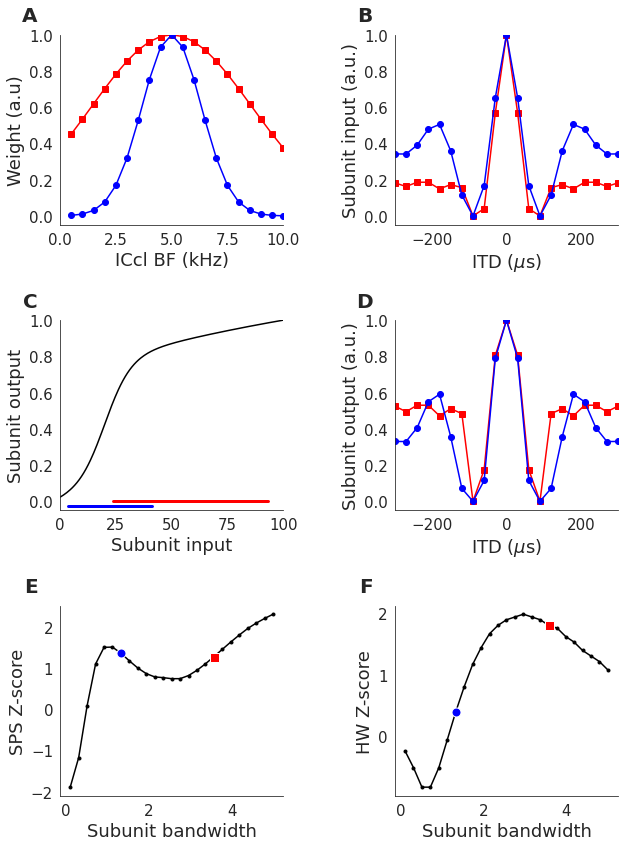

In [12]:
fig = plt.figure(figsize = (10,14))

labels = ('A', 'B', 'C','D','E','F')
ind = np.arange(0,L,30)


index = np.array([6, -8])

ax2 = plt.subplot(3,2,1)
ax2.text(-0.1, 1.15, labels[0], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

W = subunit_weights(CF,BW,bF,bITD,bF_sub,bITD_sub,sBF[index[1]],sITD)
Wf = W[:,15]/np.max(W[:,15])
plt.plot(bF,Wf,'r-s')
W = subunit_weights(CF,BW,bF,bITD,bF_sub,bITD_sub,sBF[index[0]],sITD)
Wf = W[:,15]/np.max(W[:,15])
plt.plot(bF,Wf,'b-o')

ax2.set_xlabel('ICcl BF (kHz)',fontsize = 18)
ax2.set_ylabel('Weight (a.u)',fontsize = 18)

plt.tick_params(labelsize = 15)
plt.ylim(-.05,1)
plt.xlim(0,10)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

########


ax2 = plt.subplot(3,2,2)
ax2.text(-0.1, 1.15, labels[1], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

plt.plot(ITD[ind],L_nrm[ind,index[1]],'r-s')
plt.plot(ITD[ind],L_nrm[ind,index[0]],'b-o')

ax2.set_xlabel('ITD ($\mu$s)',fontsize = 18)
ax2.set_ylabel('Subunit input (a.u.)',fontsize = 18)

plt.tick_params(labelsize = 15)
plt.ylim(-.05,1)
plt.xlim(-300,300)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#######
ax2 = plt.subplot(3,2,3)
ax2.text(-0.1, 1.15, labels[2], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')


x = np.linspace(0,100,200)
sig = sigmoidal(x,a,b,c,d,e)
sig_nrm = np.max(sig)
sig = sig/sig_nrm


L0 = np.linspace(np.min(L_icx[:,index[0]]),np.max(L_icx[:,index[0]]),200)
sig0 = sigmoidal(L0,a,b,c,d,e)/sig_nrm


L1 = np.linspace(np.min(L_icx[:,index[1]]),np.max(L_icx[:,index[1]]),200)
sig1 = sigmoidal(L1,a,b,c,d,e)/sig_nrm


plt.plot(x,sig,'k')

plt.plot(L0,np.ones(200)*-.025,'b',lw = 3)
plt.plot(L1,np.ones(200)*0,'r',lw = 3)

ax2.set_xlabel('Subunit input',fontsize = 18)
ax2.set_ylabel('Subunit output',fontsize = 18)


plt.tick_params(labelsize = 15)
plt.ylim(-.05,1)
plt.xlim(0,100)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#######
ax2 = plt.subplot(3,2,4)
ax2.text(-0.1, 1.15, labels[3], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')


plt.plot(ITD[ind],S_nrm[ind,index[1]],'r-s')
plt.plot(ITD[ind],S_nrm[ind,index[0]],'b-o')

ax2.set_xlabel('ITD ($\mu$s)',fontsize = 18)
ax2.set_ylabel('Subunit output (a.u.)',fontsize = 18)

plt.tick_params(labelsize = 15)
plt.ylim(-.05,1)
plt.xlim(-300,300)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


####

#Convert SPS to z-scores
mu = 23.18
sig = 12.27

Z_SPS = (SPS - mu)/sig
    
#Convert HW to z-scores
mu = 75.17
sig = 17.12

Z_HW = (HW - mu)/sig


ax2 = plt.subplot(3,2,5)
ax2.text(-0.1, 1.15, labels[4], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

plt.plot(sBF,Z_SPS,'-k.')
plt.plot(sBF[index[1]],Z_SPS[index[1]],'rs',mec = 'w',ms = 9)
plt.plot(sBF[index[0]],Z_SPS[index[0]],'bo',mec = 'w',ms = 9)

ax2.set_xlabel('Subunit bandwidth',fontsize = 18)
ax2.set_ylabel('SPS Z-score',fontsize = 18)

plt.tick_params(labelsize = 15)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

####

ax2 = plt.subplot(3,2,6)
ax2.text(-0.1, 1.15, labels[5], transform=ax2.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

plt.plot(sBF,Z_HW,'-k.')

plt.plot(sBF[index[1]],Z_HW[index[1]],'rs',mec = 'w',ms = 9)
plt.plot(sBF[index[0]],Z_HW[index[0]],'bo',mec = 'w',ms = 9)

ax2.set_xlabel('Subunit bandwidth',fontsize = 18)
ax2.set_ylabel('HW Z-score',fontsize = 18)

plt.tick_params(labelsize = 15)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

####

plt.subplots_adjust(wspace = 0.5,hspace = 0.5)



#from google.colab import files
#files.download("Figure6.png")

plt.show()
